# Implementing Our First Bayesian Classifier

In the previous chapter, we learned how to generate a number of Gaussian blobs using
scikit-learn. Do you remember how that is done?

## Creating a toy dataset

The function I'm referring to resides within scikit-learn's `datasets` module. Let's create 100
data points, each belonging to one of two possible classes, and group them into two
Gaussian blobs. To make the experiment reproducible, we specify an integer to pick a seed
for the `random_state`. You can again pick whatever number you prefer. Here I went with
Thomas Bayes' year of birth (just for kicks):

In [ ]:
from sklearn import datasets
X, y = datasets.make_blobs(100, 2, centers=2, random_state=1701, cluster_std=2)

Let's have a look at the dataset we just created using our trusty friend, Matplotlib:

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

I'm sure this is getting easier every time. We use scatter to create a scatter plot of all $x$
values (`X[:, 0]`) and $y$ values (`X[:, 1]`), which will result in the following output:

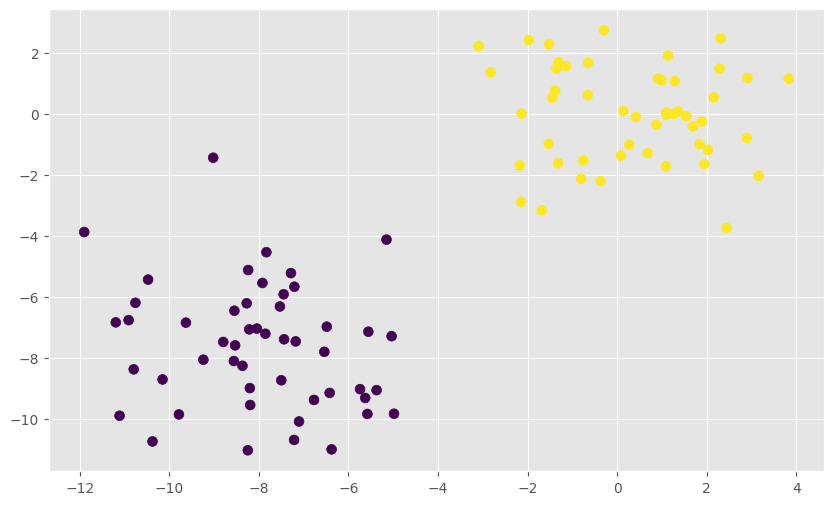

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);

In agreement with our specifications, we see two different point clusters. They hardly
overlap, so it should be relatively easy to classify them. What do you think—could a linear
classifier do the job?

Yes, it could. Recall that a linear classifier would try to draw a straight line through the
figure, trying to put all blue dots on one side and all red dots on the other. A diagonal line
going from the top-left corner to the bottom-right corner could clearly do the job. So we
would expect the classification task to be relatively easy, even for a naive Bayes classifier.

But first, don't forget to split the dataset into training and test sets! Here, I reserve 10% of
the data points for testing:

In [4]:
import numpy as np
from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    X.astype(np.float32), y, test_size=0.1
)

## Classifying the data with a normal Bayes classifier

We will then use the same procedure as in earlier chapters to train a **normal Bayes
classifier**. Wait, why not a naive Bayes classifier? Well, it turns out OpenCV doesn't really
provide a true naive Bayes classifier... Instead, it comes with a Bayesian classifier that doesn't
necessarily expect features to be independent, but rather expects the data to be clustered
into Gaussian blobs. This is exactly the kind of dataset we created earlier!

We can create a new classifier using the following function:

In [5]:
import cv2
model_norm = cv2.ml.NormalBayesClassifier_create()

Then, training is done via the `train` method:

In [6]:
model_norm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

True

Once the classifier has been trained successfully, it will return True. We go through the
motions of predicting and scoring the classifier, just like we have done a million times
before:

In [7]:
_, y_pred = model_norm.predict(X_test)

In [8]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

1.0

Even better—we can reuse the plotting function from the last chapter to inspect the decision
boundary! If you recall, the idea was to create a mesh grid that would encompass all data
points and then classify every point on the grid. The mesh grid is created via the NumPy
function of the same name:

In [9]:
def plot_decision_boundary(model, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_hypo = np.column_stack((xx.ravel().astype(np.float32),
                              yy.ravel().astype(np.float32)))
    ret = model.predict(X_hypo)
    if isinstance(ret, tuple):
        zz = ret[1]
    else:
        zz = ret
    zz = zz.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

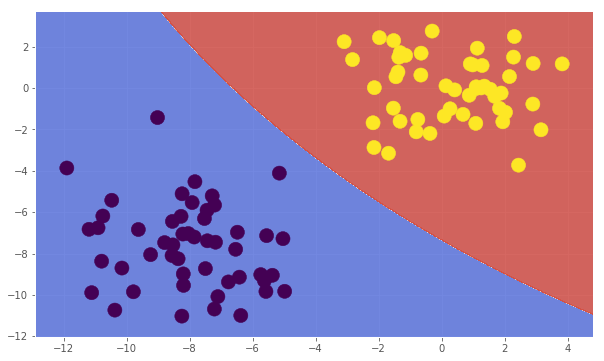

In [10]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(model_norm, X, y)

So far, so good. The interesting part is that a Bayesian classifier also returns the probability
with which each data point has been classified:

In [11]:
ret, y_pred, y_proba = model_norm.predictProb(X_test)

The function returns a Boolean flag (True for success, False for failure), the predicted
target labels (`y_pred`), and the conditional probabilities (`y_proba`). Here, y_proba is an $N
\times 2$ matrix that indicates, for every one of the $N$ data points, the probability with which it
was classified as either class 0 or class 1:

In [12]:
y_proba.round(2)

array([[0.  , 0.02],
       [0.  , 0.12],
       [0.1 , 0.  ],
       [0.  , 0.19],
       [0.  , 0.11],
       [0.  , 0.03],
       [0.12, 0.  ],
       [0.23, 0.  ],
       [0.11, 0.  ],
       [0.  , 0.  ]], dtype=float32)

## Classifying the data with a naive Bayes classifier

We can compare the result to a true naïve Bayes classifier by asking scikit-learn for help:

In [13]:
from sklearn import naive_bayes
model_naive = naive_bayes.GaussianNB()

As usual, training the classifier is done via the `fit` method:

In [14]:
model_naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Scoring the classifier is built in:

In [15]:
model_naive.score(X_test, y_test)

1.0

Again a perfect score! However, in contrast to OpenCV, this classifier's `predict_proba`
method returns true probability values, because all values are between 0 and 1, and because
all rows add up to 1:

In [16]:
yprob = model_naive.predict_proba(X_test)
yprob.round(2)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

You might have noticed something else: This classifier has absolutely no doubt about the
target label of each and every data point. It's all or nothing.

The decision boundary returned by the naive Bayes classifier looks slightly different, but
can be considered identical to the previous command for the purpose of this exercise:

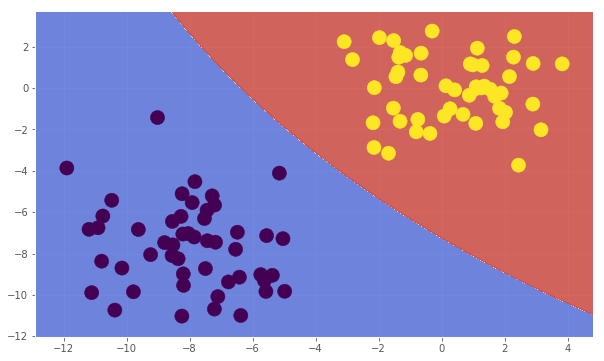

In [17]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(model_naive, X, y)

## Visualizing conditional probabilities

Similarly, we can also visualize probabilities. For this, we slightly modify the plot function
from the previous example. We start out by creating a mesh grid between (`x_min`, `x_max`)
and (`y_min`, `y_max`):

In [18]:
def plot_proba(model, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_hypo = np.column_stack((xx.ravel().astype(np.float32),
                              yy.ravel().astype(np.float32)))
    if hasattr(model, 'predictProb'):
        _, _, y_proba = model.predictProb(X_hypo)
    else:
        y_proba = model.predict_proba(X_hypo)
    
    zz = y_proba[:, 1] - y_proba[:, 0]
    zz = zz.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

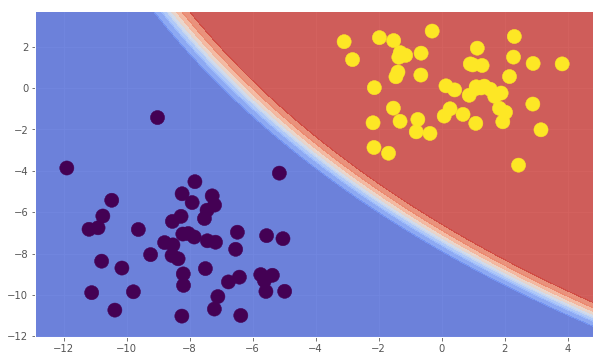

In [19]:
plt.figure(figsize=(10, 6))
plot_proba(model_naive, X, y)